* Three classification neural network  and evaluate there fraction error and choose the best one

In [74]:
# for array computations and loading data
import numpy as np

# for ploting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# for building linear regression models and preparing data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for building and training neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# reduce display precision on numpy arrays
np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Ensure TensorFlow uses deterministic operations
tf.config.experimental.enable_op_determinism()

# Set seeds for reproducibility
tf.random.set_seed(20)
np.random.seed(20)

In [89]:
# Load the dataset from a text file
data = np.loadtxt('/Users/berekettesfaye/Desktop/ML_projects/coursera_evaluation/data_w3_ex2.csv', delimiter = ',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_bc = np.expand_dims(y_bc, axis=1)
print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


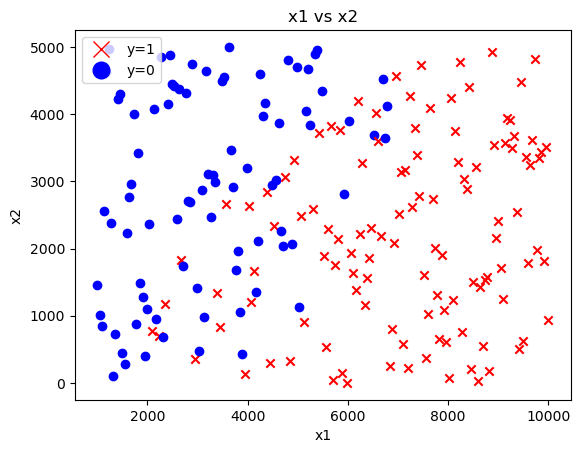

In [76]:

# plot the data set
def plot_bc_dataset(x, y, title):
    for i in range(len(y)):
        marker = 'x' if y[i] == 1 else 'o'
        c = 'r' if y[i] == 1 else 'b'
        plt.scatter(x[i,0], x[i,1], marker=marker, c=c); 
    plt.title("x1 vs x2")
    plt.xlabel("x1"); 
    plt.ylabel("x2"); 
    y_0 = mlines.Line2D([], [], color='r', marker='x', markersize=12, linestyle='None', label='y=1')
    y_1 = mlines.Line2D([], [], color='b', marker='o', markersize=12, linestyle='None', label='y=0')
    plt.title(title)
    plt.legend(handles=[y_0, y_1])
    plt.show()

plot_bc_dataset(x=x_bc, y= y_bc,title="x1 vs x2")

In [77]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train,y_ = train_test_split(x_bc,y_bc,test_size = 0.40, random_state = 1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv,x_bc_test,y_bc_cv,y_bc_test = train_test_split(x_,y_,test_size = 0.5, random_state = 1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


In [78]:
# scale features

# Intialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

In [79]:

# build the neural network architectures 
def build_models():
    tf.random.set_seed(20)
    model_1 = Sequential(
        [
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name = 'model_1'
    )

    
    model_2 = Sequential(
        [
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name = 'model_2'
    )
    
    
    model_3 = Sequential(
        [
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name = 'model_3'
    )

    model_list = [model_1, model_2, model_3]

    return model_list
    

In [83]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# Build the models
models_bc = build_models()

for model in models_bc:
    tf.random.set_seed(20)
    np.random.seed(20)
    # setup the loss and optimizer
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    )
    print(f"Training {model.name}...")
    
    model.fit(
        x_bc_train_scaled,y_bc_train,
        epochs=200,
        verbose= 0,
        shuffle= False
    )
    print("Done!\n")

    # set the threshold for classifiction
    threshold = 0.5

    # Record the fraction of misclassification examples for the training set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1,0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified example of the cross validation set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold,1,0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )
    

Training model_1...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
Training model_2...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
Training model_3...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
Model 1: Training Set Classification Error: 0.07500, CV Set Classification Error: 0.15000
Model 2: Training Set Classification Error: 0.13333, CV Set Classification Error: 0.20000
Model 3: Training Set Classification Error: 0.10833, CV Set Classification Error: 0.17500


* from the output above, i will choose the model which performs the best on the cross validation and training set  and if there was a tie its better to choose the smaller model becuase it saves computational resources
* finally i will compute the test error to report the models generalization error

In [86]:
# Select the model error
model_num = 1

# compute the test error
yhat = models_bc[model_num -1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold,1,0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Selected Model: 1
Training Set Classification Error: 0.0750
CV Set Classification Error: 0.1500
Test Set Classification Error: 0.1250


* Wrap up
  - 